In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns



%matplotlib inline
plt.style.use('ggplot')

In [75]:
!ls data/

sample_submission.csv test.csv              train.csv


In [86]:
df = pd.read_csv('data/train.csv')

In [87]:
df.shape

(913000, 4)

In [88]:
df.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [89]:
df.isnull().sum()

date     0
store    0
item     0
sales    0
dtype: int64

In [90]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   store   913000 non-null  int64 
 2   item    913000 non-null  int64 
 3   sales   913000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 27.9+ MB


In [91]:
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')

In [92]:
df.head()

,store,item,sales
date,,,
2013-01-01,1,1,13
2013-01-02,1,1,11
2013-01-03,1,1,14
2013-01-04,1,1,13
2013-01-05,1,1,10


In [148]:
df['year']= df.index.year
df['month']= df.index.month
df['year_and_month']= df.index.year.astype('str') + '-' + df.index.month.astype('str')

In [149]:
df.tail()

,store,item,sales,year,month,year_and_month
date,,,,,,
2017-12-27,10,50,63,2017,12,2017-12
2017-12-28,10,50,59,2017,12,2017-12
2017-12-29,10,50,74,2017,12,2017-12
2017-12-30,10,50,62,2017,12,2017-12
2017-12-31,10,50,82,2017,12,2017-12


In [140]:
def plot_trend_data(ax, name, series):
    ax.plot(series.index, series.values)
    ax.set_title("Sales Trend For {}".format(name))

In [142]:
monthly = df.groupby(pd.Grouper(freq='M'))['sales'].sum()
monthly.columns =['sales']
monthly

date
2013-01-31     454904
2013-02-28     459417
2013-03-31     617382
2013-04-30     682274
2013-05-31     763242
2013-06-30     795597
2013-07-31     855922
2013-08-31     766761
2013-09-30     689907
2013-10-31     656587
2013-11-30     692643
2013-12-31     506607
2014-01-31     525987
2014-02-28     529117
2014-03-31     704301
2014-04-30     788914
2014-05-31     882877
2014-06-30     906842
2014-07-31     989010
2014-08-31     885596
2014-09-30     785124
2014-10-31     758883
2014-11-30     800783
2014-12-31     578048
2015-01-31     552513
2015-02-28     551317
2015-03-31     730951
2015-04-30     824467
2015-05-31     926902
2015-06-30     937184
2015-07-31    1037350
2015-08-31     920401
2015-09-30     823332
2015-10-31     797253
2015-11-30     827645
2015-12-31     607572
2016-01-31     602439
2016-02-29     614957
2016-03-31     790881
2016-04-30     901950
2016-05-31     988730
2016-06-30    1022664
2016-07-31    1138718
2016-08-31     981494
2016-09-30     896831
2016-

AttributeError: module 'matplotlib.pyplot' has no attribute 'saveimg'

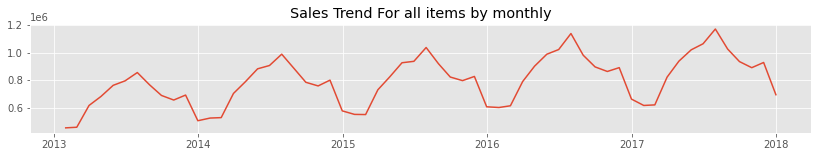

In [153]:
fig, ax = plt.subplots(1, figsize=(14, 2))
plot_trend_data(ax, 'all items by monthly', monthly)
plt.saveimg('images/all_items_by_monthly.png')

In [151]:
daily = df.groupby(pd.Grouper(freq='D'))['sales'].sum()
daily.columns =['sales']
daily

date
2013-01-01    13696
2013-01-02    13678
2013-01-03    14488
2013-01-04    15677
2013-01-05    16237
              ...  
2017-12-27    20378
2017-12-28    21885
2017-12-29    23535
2017-12-30    24988
2017-12-31    26420
Freq: D, Name: sales, Length: 1826, dtype: int64

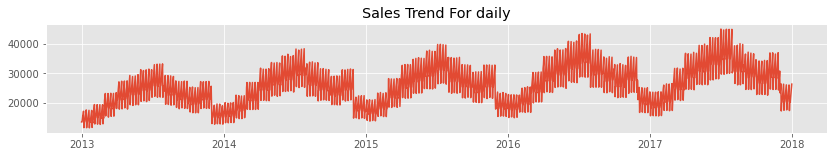

In [145]:
fig, ax = plt.subplots(1, figsize=(14, 2))
plot_trend_data(ax, 'daily', daily)

In [74]:
years = pd.DataFrame()
for name, group in groups:
    print(name, group)
#     years[name.year] = group.values
# years.plot(subplots=True, legend=False)
# pyplot.show()

TypeError: cannot unpack non-iterable int object

In [137]:
def plot_trend_data(ax, name, series):
    ax.plot(series.index, series.values)
    ax.set_title("Sales Trend For {}".format(name))

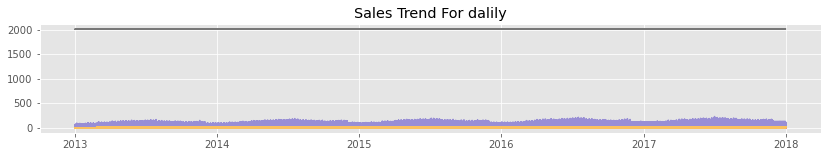

In [138]:
# show the total sales trend
fig, ax = plt.subplots(1, figsize=(14, 2))
plot_trend_data(ax, 'dalily', df)

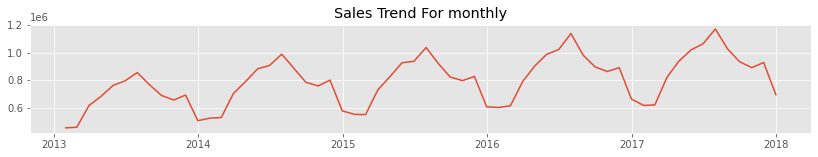

In [139]:
fig, ax = plt.subplots(1, figsize=(14, 2))
plot_trend_data(ax, 'monthly', monthly)

In [134]:
monthly.values

array([ 454904,  459417,  617382,  682274,  763242,  795597,  855922,
        766761,  689907,  656587,  692643,  506607,  525987,  529117,
        704301,  788914,  882877,  906842,  989010,  885596,  785124,
        758883,  800783,  578048,  552513,  551317,  730951,  824467,
        926902,  937184, 1037350,  920401,  823332,  797253,  827645,
        607572,  602439,  614957,  790881,  901950,  988730, 1022664,
       1138718,  981494,  896831,  863637,  891448,  663411,  617306,
        621369,  822667,  938862, 1020686, 1064624, 1171393, 1026403,
        935263,  891160,  928837,  695170])